# When people write Yelp reviews for restaurants, which aspects do they value more? 
Food, ambience, parking, service or wait time? How do the reviewers weigh these categories, 
and how are they reflected on the overall star ratings? My guess to this question is that food quality 
would be the most important thing when making an evaluation for a restaurant. Even if other aspects 
such as service and parking are not that great, as long as they are not horrible that it takes 
half an hour to find a parking spot or place an order, it should not affect the overall ratings. 
I am also curious to find out the line between what's acceptable or not in those categories. 
To what extent can people tolerate? 


## Background
It is obvious that star ratings are the ones that influence first impression the most on Yelp; an extra half-star rating causes restaurants to sell out 19 percentage points (49%) more frequently (Anderson). This shows how important they are when shaping a restaurants' impressions, and because they can influence the newcomers to the restaurant so much, they need to be presented more accurately. 

But since the yelp reviews are rounded up by half stars, a restaurant with score of 3.45 and another with a score of 3.52 would be rounded to 3.0 and 3.5 stars, respectively. Though their raw scores differ by .07, their official ratings differ by 0.5 and their star colors would also be different – visually affecting the users when they judge a restaurant solely on the star rating.

Data from Yelp Dataset Challenge will be used (https://www.yelp.com/dataset_challenge).


## Data Analysis

Initial analysis: Separate reviews by using individual words as tokens. Get simple frequency of each word after stemming and removing stop words to cluster similar words with different forms. 

There are five different datasets provided by Yelp as json files: business, checkin, review, tip, and user. I will be using "review" first to see the initial results. 


### Loading Data from Yelp

In [8]:
import json
import os
import numpy as np
import random
import nltk
import sys

# Weird unicode error processing some of the tweets
import re
import sys

from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

dir = os.path.abspath('__file__' + '/../')

file_name = 'yelp_academic_dataset_review.json'
full_name = os.path.join(dir, file_name)

tokens = []
test_string = ""

def load_exp_reviews(fname):
    # to keep track of # of loaded reviews
    count = 0
    string = ""

    print("processing reviews...", '\n')
    
    # Identify stopwords to remove
    stop_words = set(stopwords.words('english'))
    
    # create stemmer to stem words
    stemmer=SnowballStemmer("english")
        
    with open(fname,'r', encoding='utf-8') as f:
        for row in f:
            
            # only load first 300 for now
            if(count > 300):
                break
            
            review = json.loads(row)
            count += 1
            
            review_text = review["text"]
            review_text = review_text.lower()
            
            review_text = re.sub(r"[\.]{3,}", ' ', review_text)
            review_text = re.sub(r"[()]", '', review_text)
            
            # remove stop words
            review_text = ' '.join([word for word in review_text.split() if word not in stop_words])
            
            # stem words
            review_words=str.split(str(review_text),' ')

            for word in review_words:
                stemmed = stemmer.stem(word)
                if (len(stemmed)>0):
                    tokens.append(stemmed)
                    string += stemmed
                    string += " "
                    
    print(tokens, "\n")
    #print(string)
    print("done - loaded exp tweets")
    
    return tokens, string
    
word_list, word_string = load_exp_reviews(full_name)



processing reviews... 

['mr', 'hoagi', 'institution.', 'walk', 'in,', 'seem', 'like', 'throwback', '30', 'year', 'ago,', 'old', 'fashion', 'menu', 'board,', 'booth', '70s,', 'larg', 'select', 'food.', 'special', 'italian', 'hoagie,', 'vote', 'best', 'area', 'year', 'year.', 'usual', 'order', 'burger,', 'patti', 'obvious', 'cook', 'frozen,', 'ingredi', 'fresh.', 'overall,', 'good', 'altern', 'subway,', 'road.', 'excel', 'food.', 'superb', 'custom', 'service.', 'miss', 'mario', 'machin', 'use', 'have,', 'it', 'still', 'great', 'place', 'steep', 'tradition.', 'yes', 'place', 'littl', 'date', 'open', 'weekend.', 'staff', 'alway', 'pleasant', 'fast', 'make', 'order.', 'alway', 'spot', 'fresh', 'veggi', 'hoggi', 'food.', 'also', 'daili', 'special', 'ice', 'cream', 'realli', 'good.', 'banana', 'split', 'pile', 'top', 'on.', 'win', 'pennysav', 'award', 'ever', 'year', 'see', 'why.', 'food', 'great', 'here.', 'best', 'thing', 'wings.', 'wing', 'simpli', 'fantastic!!', '"wet', 'cajun"', 'best',

### Generating word cloud

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.misc import imread

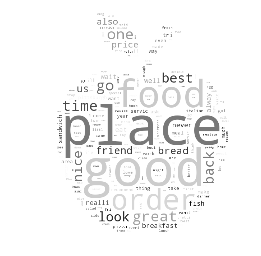

In [11]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(0, 100)

dir = os.path.abspath('__file__' + '/../')

font_file_name = 'DroidSansMono.ttf'
font_full_name = os.path.join(dir, font_file_name)

# read the mask image
# taken from
# https://image.freepik.com/free-icon/apple-black-silhouette-with-a-leaf_318-62258.png

image_file_name = 'apple.jpg'
mask = imread(os.path.join(dir, image_file_name))

#wordcloud = WordCloud().generate(tokens)

wordcloud = WordCloud(mask=mask, font_path=font_full_name, margin = 10, background_color='white', random_state = 1).generate(word_string)
# store to jpg file
wordcloud.to_file("apple_cloud.png")

# Open a plot of the generated image.
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3))
wordcloud.to_file("apple_cloud_bw.png")
plt.axis("off")
plt.show()

### Counting frequency of words
We will use scikit learn's CountVectorizer for n-gram extraction

In [34]:
from collections import Counter
from nltk import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer

def calc_freq(words):
    
    freq_dist = nltk.FreqDist(words)
    word_features = freq_dist.keys()

    #print (freq_dist.values())
    
    vocab = sorted(freq_dist)
    print (vocab.keys()[0:20])
    
calc_freq(word_list)

AttributeError: 'list' object has no attribute 'keys'

## References
1. M. Anderson and J. Magruder. “Learning from the Crowd.” The Economic Journal. 2011. 
2. wordcloud by A. Muller https://github.com/amueller/word_cloud